In [1]:
# original script: https://zenodo.org/records/4090925
# Here I want to rewrite it with biotite and expand it to use for globular protein

from __future__ import annotations

from pathlib import Path
from typing import Optional, Tuple, Union, Dict, List

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.database.rcsb as rcsb
import biotite.structure.io.pdbx as pdbx
import biotite.structure.io.pdb as pdbio

from IPython.display import SVG, display


# ===== Bead SVG style (same setting as atom2svg) =====
RADIUS = 10 # radius of the circles representing residues (in pixels)
MARGIN = 5.0 # margin around the circles (in pixels)

# Schematic spacing (increase these if you have many labels)
DX = 3.0 # horizontal spacing between residues (in pixels)
DY = 10.0 # vertical spacing between rows (in pixels)
BRANCH = 2 # horizontal spacing for branches (in pixels)
STEM_W = 0.7 # width of the stem (in pixels)

# Backbone widths by SSE
LW_BETA  = 3 # width of the line representing beta strands (in pixels)
LW_HELIX = 3 # width of the line representing helices (in pixels)
LW_LOOP  = 0.2 # width of the line representing loops (in pixels)

# Labels
LABEL_EVERY = 7 # label every n-th residue (set to 1 to label all residues)
RESI_OFFSET_PTS = (0, 10) # offset of the residue number label from the circle center (in pixels)
FONT_AA = 10 # font size for the one-letter amino acid code (in points)
FONT_RESI = 6 # font size for the residue number (in points)

# Schematic wrapping
MAX_PER_ROW = 40 # maximum number of residues per row

# Overlap guarantee
MAX_INFLATE_ITERS = 12 # maximum number of iterations to inflate the circles to resolve overlaps
INFLATE_FACTOR = 1.18 # factor by which to inflate the circles in each iteration (e.g. 1.18 means increasing the radius by 18% in each iteration)


one_letter_code = {'ARG': 'R', 'HIS': 'H', 'LYS': 'K', 'ASP': 'D', 'GLU': 'E',
                   'SER': 'S', 'THR': 'T', 'ASN': 'N', 'GLN': 'Q', 'CYS': 'C',
                   'GLY': 'G', 'PRO': 'P', 'ALA': 'A', 'VAL': 'V', 'ILE': 'I',
                   'LEU': 'L', 'MET': 'M', 'PHE': 'F', 'TYR': 'Y', 'TRP': 'W'}

residue_class = {'ARG': 'b', 'HIS': 'b', 'LYS': 'b', 'ASP': 'a', 'GLU': 'a',
                 'SER': 'w', 'THR': 'w', 'ASN': 'w', 'GLN': 'w', 'CYS': 's',
                 'GLY': 'g', 'PRO': 'p', 'ALA': 'n', 'VAL': 'n', 'ILE': 'n',
                 'LEU': 'n', 'MET': 's', 'PHE': 'n', 'TYR': 'n', 'TRP': 'n'}

CLASS_TO_FILL = {
    "a": "red", "b": "skyblue", "w": "green", "g": "pink",
    "n": "white", "s": "yellow", "p": "purple",
}

def aa1(res3: str) -> str:
    return one_letter_code.get(res3.upper(), "X")

def aa_class(res3: str) -> str:
    return residue_class.get(res3.upper(), "n")



In [2]:
def load_structure_local(path: Union[str, Path], model: int = 1) -> struc.AtomArray:
    arr = strucio.load_structure(str(path))
    if isinstance(arr, struc.AtomArrayStack):
        idx = max(0, min(arr.stack_depth() - 1, model - 1))
        arr = arr[idx]
    return arr

def load_structure_rcsb_safe(pdb_id: str, model: int = 1):
    """
    Robust structure fetcher:
    - Try bcif (fast) but some entries crash in Biotite due to ins_code decoding
    - Fall back to cif
    - Fall back to pdb

    Returns:
      (atom_array, pdbx_file_or_none)

    If pdbx_file is not None, you can try pdbx.get_sse(pdbx_file).
    """
    pdb_id = pdb_id.upper()

    # 1) Try bcif
    try:
        bcif_path = rcsb.fetch(pdb_id, "bcif")
        bcif = pdbx.BinaryCIFFile.read(bcif_path)
        arr = pdbx.get_structure(bcif, model=model)
        # If it returns AtomArrayStack for some reason, pick first
        if hasattr(arr, "stack_depth"):
            arr = arr[0]
        return arr, bcif
    except Exception as e_bcif:
        print(f"[load_structure_rcsb_safe] bcif failed ({type(e_bcif).__name__}): {e_bcif}")

    # 2) Try cif
    try:
        cif_path = rcsb.fetch(pdb_id, "cif")
        cif = pdbx.CIFFile.read(cif_path)
        arr = pdbx.get_structure(cif, model=model)
        if hasattr(arr, "stack_depth"):
            arr = arr[0]
        return arr, cif
    except Exception as e_cif:
        print(f"[load_structure_rcsb_safe] cif failed ({type(e_cif).__name__}): {e_cif}")

    # 3) Try pdb
    pdb = pdbio.PDBFile.read(rcsb.fetch(pdb_id, "pdb"))
    arr = pdbio.get_structure(pdb, model=model)
    if hasattr(arr, "stack_depth"):
        arr = arr[0]
    return arr, None

def select_chain_amino_acids(arr: struc.AtomArray, chain_id: str) -> struc.AtomArray:
    return arr[struc.filter_amino_acids(arr) & (arr.chain_id == chain_id)]

def residue_table_full_chain(arr: struc.AtomArray, chain_id: str, *, pdbx_file=None):
    """
    Return (res_ids, res_names) for *all residues* in the chain.

    Priority:
      1) Use mmCIF polymer sequence (includes unresolved residues) if pdbx_file is available.
      2) Fallback to residues present in AtomArray (may miss unresolved).
    """
    # --- 1) polymer sequence from mmCIF/bCIF ---
    if pdbx_file is not None:
        try:
            # Get entity polymer sequences and map entity->chains
            ent = pdbx_file.block["entity_poly"]
            poly = pdbx_file.block["pdbx_poly_seq_scheme"]

            # Build chain -> entity_id mapping from scheme table
            # NOTE: column names vary slightly across files; try robustly
            chain_col = "pdb_strand_id" if "pdb_strand_id" in poly else "asym_id"
            ent_col   = "entity_id"
            mon_col   = "mon_id"  # 3-letter residues
            seq_col   = "seq_id"  # 1..N

            chain_ids = np.asarray(poly[chain_col].as_array(str), dtype=object)
            ent_ids   = np.asarray(poly[ent_col].as_array(int), dtype=int)
            mon_ids   = np.asarray(poly[mon_col].as_array(str), dtype=object)
            seq_ids   = np.asarray(poly[seq_col].as_array(int), dtype=int)

            # Filter to requested chain
            mask = (chain_ids == chain_id)
            if np.any(mask):
                seq_ids_f = seq_ids[mask]
                mon_ids_f = mon_ids[mask]

                # Sort by seq_id (polymer position)
                order = np.argsort(seq_ids_f)
                seq_ids_f = seq_ids_f[order]
                mon_ids_f = mon_ids_f[order]

                # Use seq_id as our plotting res_ids (1..N)
                # If you prefer author res_id numbering, we can map later.
                return seq_ids_f.astype(int), mon_ids_f.astype(str)
        except Exception as e:
            print(f"[residue_table_full_chain] mmCIF polymer seq failed: {type(e).__name__}: {e}")

    # --- 2) fallback: residues present in structure (resolved only) ---
    aa = select_chain_amino_acids(arr, chain_id)
    starts = struc.get_residue_starts(aa)
    res_ids = aa.res_id[starts].astype(int)
    res_names = aa.res_name[starts].astype(str)

    # Sort by (res_id, ins_code) if available
    if "ins_code" in aa.get_annotation_categories():
        ins = np.array([("" if x is None else str(x)) for x in aa.ins_code[starts]], dtype=object)
        order = np.lexsort((ins, res_ids))
    else:
        order = np.argsort(res_ids)

    return res_ids[order], res_names[order]



In [3]:
import numpy as np
import biotite.structure as struc
import biotite.structure.io.pdbx as pdbx


def sse_to_coarse(s: str) -> str:
    """
    Convert various SSE codes into:
      'E' beta, 'H' helix, '-' loop
    """
    if s in ("E", "B", "b"):          # sheet-ish
        return "E"
    if s in ("H", "G", "I", "a"):     # helix-ish (PSEA uses 'a' sometimes)
        return "H"
    return "-"


def _norm_ins(x) -> str:
    return "" if (x is None or str(x).strip() == "") else str(x)


def _residue_index(aa: struc.AtomArray):
    """
    Return per-residue indexing for aa:
      - starts: atom indices for residue starts
      - keys: (res_id, ins_code) per residue, ordered as in structure
    """
    starts = struc.get_residue_starts(aa)

    res_id = aa.res_id[starts].astype(int)

    if "ins_code" in aa.get_annotation_categories():
        ins = np.array([_norm_ins(x) for x in aa.ins_code[starts]], dtype=object)
    else:
        ins = np.array([""] * len(starts), dtype=object)

    keys = np.array(list(zip(res_id, ins)), dtype=object)
    return starts, keys


def _coarse_array(raw) -> np.ndarray:
    raw = np.asarray(list(raw), dtype="<U1")
    return np.array([sse_to_coarse(x) for x in raw], dtype="<U1")


def get_sse_biotite(arr: struc.AtomArray, chain_id: str, *, pdbx_file=None, max_slop: int = 5) -> np.ndarray:
    """
    SSE per residue for chain_id, aligned to *residues* (not CA atoms).

    Preference order (maximize use of embedded annotations):
      1) pdbx.get_sse(pdbx_file)[chain_id] if available (embedded in mmCIF/bCIF)
      2) if arr/aa already carries an SSE annotation category, use it
      3) DSSP (recalc)
      4) struc.annotate_sse (recalc fallback)

    Returns coarse SSE array of length = number of residues in chain:
      'E', 'H', '-'
    """
    aa = select_chain_amino_acids(arr, chain_id)

    # Robust residue count/index (does NOT depend on CA existing)
    starts, keys = _residue_index(aa)
    n_res = len(starts)

    # -------------------------
    # 1) Embedded SSE in pdbx
    # -------------------------
    if pdbx_file is not None:
        try:
            sse_map = pdbx.get_sse(pdbx_file)
            print(f"[get_sse_biotite] SSE map from pdbx keys: {list(sse_map.keys())}")
            if chain_id in sse_map:
                raw = sse_map[chain_id]  # string-like per residue
                print(f"[get_sse_biotite] Raw SSE from pdbx for chain {chain_id}: {raw[:50]}... (length {len(raw)})")
                coarse = _coarse_array(raw)
                print(f"[get_sse_biotite] Coarse SSE from pdbx for chain {chain_id}: {coarse[:50]}... (length {len(coarse)})")
                return coarse
        except Exception:
            print(f"[get_sse_biotite] Failed to get SSE from pdbx for chain {chain_id}.")
            pass

    # ----------------------------------------------------
    # 2) SSE already stored as an annotation in the AtomArray
    # ----------------------------------------------------
    # Depending on how loaded, structure may carry an SSE category (rare but happens).
    # We'll look for likely category names.
    cats = set(aa.get_annotation_categories())
    for cat in ("sse", "sec_struct", "secondary_structure"):
        if cat in cats:
            try:
                raw = aa.get_annotation(cat)
                # raw is per-atom: reduce to per-residue by taking first atom of each residue
                raw_res = np.asarray(raw)[starts]
                coarse = np.array([sse_to_coarse(str(x)[0]) for x in raw_res], dtype="<U1")
                return coarse
            except Exception:
                print(f"[get_sse_biotite] Failed to get SSE from annotation '{cat}' for chain {chain_id}.")
                pass

    # -------------------------
    # 3) DSSP (recalculate)
    # -------------------------
    try:
        from biotite.application.dssp import DsspApp
        app = DsspApp(aa)
        app.start(); app.join()
        coarse = _coarse_array(app.get_sse())
        return coarse
    except Exception:
        pass

    # -------------------------
    # 4) annotate_sse (recalculate)
    # -------------------------
    try:
        coarse = _coarse_array(struc.annotate_sse(aa))
        return coarse
    except Exception:
        pass

    return np.array(["-"] * n_res, dtype="<U1")


In [4]:
def build_feature_map_layout(res_ids: np.ndarray, res_names: np.ndarray, sse: np.ndarray):
    """
    Make a 2D schematic like a feature map:
      - residues laid out on rows with wrap
      - row direction snakes to reduce crossings
      - beads staggered above/below the rail
      - SSE affects line width later (not geometry)
    """
    n = len(res_ids)
    rail_xy = np.zeros((n,2), float)

    row = 0
    col = 0
    # direction = 1  # 1 left->right, -1 right->left

    for i in range(n):
        if col >= MAX_PER_ROW:
            row += 1
            col = 0
            # direction *= -1

        x = col * DX
        y = -row * DY
        # if direction == -1:
        #     x = (MAX_PER_ROW - 1 - col) * DX
        rail_xy[i] = (x, y)
        col += 1

    rail_xy -= rail_xy.mean(axis=0, keepdims=True)
    
    rows = np.arange(n) // MAX_PER_ROW

    # Tangent vector d, but never use points from a different row
    d = np.zeros_like(rail_xy)

    for i in range(n):
        row = rows[i]

        prev_i = i - 1
        next_i = i + 1

        has_prev = (prev_i >= 0) and (rows[prev_i] == row)
        has_next = (next_i < n) and (rows[next_i] == row)

        if has_prev and has_next:
            # central difference within the row
            d[i] = rail_xy[next_i] - rail_xy[prev_i]
        elif has_next:
            # forward difference (row start)
            d[i] = rail_xy[next_i] - rail_xy[i]
        elif has_prev:
            # backward difference (row end)
            d[i] = rail_xy[i] - rail_xy[prev_i]
        else:
            d[i] = np.array([1.0, 0.0])  # single residue row edge-case

    dn = np.linalg.norm(d, axis=1, keepdims=True)
    dn[dn == 0] = 1.0
    t = d / dn
    normal = np.stack([-t[:, 1], t[:, 0]], axis=1)


    side = np.where((np.arange(n) % 2) == 0, 1.0, -1.0)
    gly = np.array([rn.upper() == "GLY" for rn in res_names], dtype=bool)
    branch = np.where(gly, BRANCH*0.6, BRANCH)

    bead_xy = rail_xy + (side[:,None] * branch[:,None]) * normal
    seg_tag = sse[:-1]  # per segment i->i+1
    return rail_xy, bead_xy, seg_tag


In [5]:
from matplotlib.patches import Circle

def plot_for_overlap(
    ax, rail_xy, bead_xy, res_ids, res_names, seg_tag,
    *,
    label_period=10,
    label_mode="absolute",   # "absolute" or "relative"
    ):
    """
    Matplotlib preview used for overlap detection.
    - beta (E): thick solid
    - helix (H): dashed
    - loop (-): thin solid
    """
    # --- Backbone segments with SSE-dependent linewidth + linestyle ---
    for i in range(len(rail_xy) - 1):

        row_i = i // MAX_PER_ROW
        row_j = (i + 1) // MAX_PER_ROW

        if row_i != row_j:
            continue


        row_i = i // MAX_PER_ROW
        row_j = (i + 1) // MAX_PER_ROW

        if row_i != row_j:
            continue   # ← skip row-crossing segment
        x1, y1 = rail_xy[i]
        x2, y2 = rail_xy[i + 1]
        t = seg_tag[i]

        if t == "E":
            lw = LW_BETA
            ls = "solid"
        elif t == "H":
            lw = LW_HELIX
            ls = (0, (1, 2))
        else:
            lw = LW_LOOP
            ls = "solid"

        ax.plot([x1, x2], [y1, y2],
                color="black",
                linewidth=lw,
                linestyle=ls,
                solid_capstyle="round",
                solid_joinstyle="miter",
                zorder=1)

    first_rid = int(res_ids[0]) if len(res_ids) > 0 else 0

    # --- Stems + beads + labels ---
    for (rx, ry), (bx, by), rid, rn in zip(rail_xy, bead_xy, res_ids, res_names):
        rid_int = int(rid)

        # stem
        vx = bx - rx
        vy = by - ry
        norm = (vx**2 + vy**2)**0.5 + 1e-12
        bx_edge = bx - RADIUS * vx / norm
        by_edge = by - RADIUS * vy / norm

        ax.plot([rx, bx_edge], [ry, by_edge],
                color="black",
                linewidth=STEM_W,
                zorder=2)

        # bead
        cls = aa_class(rn)
        fill = CLASS_TO_FILL.get(cls, "white")
        ax.add_patch(
            Circle((bx, by), radius=RADIUS,
                   facecolor=fill, edgecolor="black", linewidth=0.8, zorder=3)
        )

        # resn inside bead
        ax.text(bx, by, aa1(rn),
                ha="center", va="center",
                fontsize=FONT_AA, fontweight="bold",
                zorder=4, color="black")

        # ---- ONLY label every N residues ----
        show = False
        if label_period and label_period > 0:
            if label_mode == "relative":
                show = ((rid_int - first_rid) % label_period == 0)
            else:
                show = (rid_int % label_period == 0)

        if show:
            # place resi along stem direction, outside the bead
            ux, uy = vx / norm, vy / norm
            gap = 4.0
            tx = bx + (RADIUS + gap) * ux
            ty = by + (RADIUS + gap) * uy

            ax.text(tx, ty, str(rid_int),
                    ha="center", va="center",
                    fontsize=FONT_RESI,
                    zorder=4, color="black")

    ax.set_aspect("equal", adjustable="datalim")
    ax.axis("off")


In [6]:

def collect_bboxes(fig, ax): 
    fig.canvas.draw() 
    renderer = fig.canvas.get_renderer() 
    bboxes = [] 
    for txt in ax.texts: 
        bboxes.append(txt.get_window_extent(renderer=renderer)) 
    for p in ax.patches: 
        bboxes.append(p.get_window_extent(renderer=renderer)) 
    for c in ax.collections: 
        try: 
            bboxes.append(c.get_window_extent(renderer=renderer)) 
        except Exception: 
            pass 
    for ln in ax.lines: 
        try: 
            bboxes.append(ln.get_window_extent(renderer=renderer)) 
        except Exception: 
            pass 
    return bboxes 

def any_bbox_overlap(bboxes, eps_px: float = 0.5) -> bool: 
    for i in range(len(bboxes)): 
        a = bboxes[i].expanded(1.0 + eps_px/1000, 1.0 + eps_px/1000) 
        for j in range(i+1, len(bboxes)): 
            b = bboxes[j].expanded(1.0 + eps_px/1000, 1.0 + eps_px/1000) 
            if a.overlaps(b): 
                return True 
    return False

def inflate_until_clean(rail_xy, bead_xy, res_ids, res_names, seg_tag, *, label_period=10, label_mode="absolute"):

    scale = 1.0
    for _ in range(MAX_INFLATE_ITERS):
        fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
        plot_for_overlap(ax, rail_xy*scale, bead_xy*scale, res_ids, res_names, seg_tag,
                 label_period=label_period, label_mode=label_mode)

        fig.tight_layout(pad=0.1)
        bboxes = collect_bboxes(fig, ax)
        overlap = any_bbox_overlap(bboxes)
        plt.close(fig)
        if not overlap:
            return scale
        scale *= INFLATE_FACTOR
    return scale


[load_structure_rcsb_safe] bcif failed (DeserializationError): Failed to deserialize element 'pdbx_PDB_ins_code'
Loaded structure 4W4O chain A with 224 residues.
[get_sse_biotite] SSE map from pdbx keys: ['A', 'B', 'C']
[get_sse_biotite] Raw SSE from pdbx for chain A: ['c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'b' 'b' 'b'
 'b' 'b' 'c' 'c' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'c' 'c' 'c' 'c' 'c' 'b' 'b'
 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c' 'c' 'c' 'c']... (length 224)
[get_sse_biotite] Coarse SSE from pdbx for chain A: ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' 'E' 'E' 'E'
 'E' 'E' '-' '-' 'H' 'H' 'H' 'H' 'H' 'H' 'H' '-' '-' '-' '-' '-' 'E' 'E'
 'E' 'E' 'E' 'E' 'E' 'E' 'E' '-' '-' '-' '-' '-' '-' '-']... (length 224)


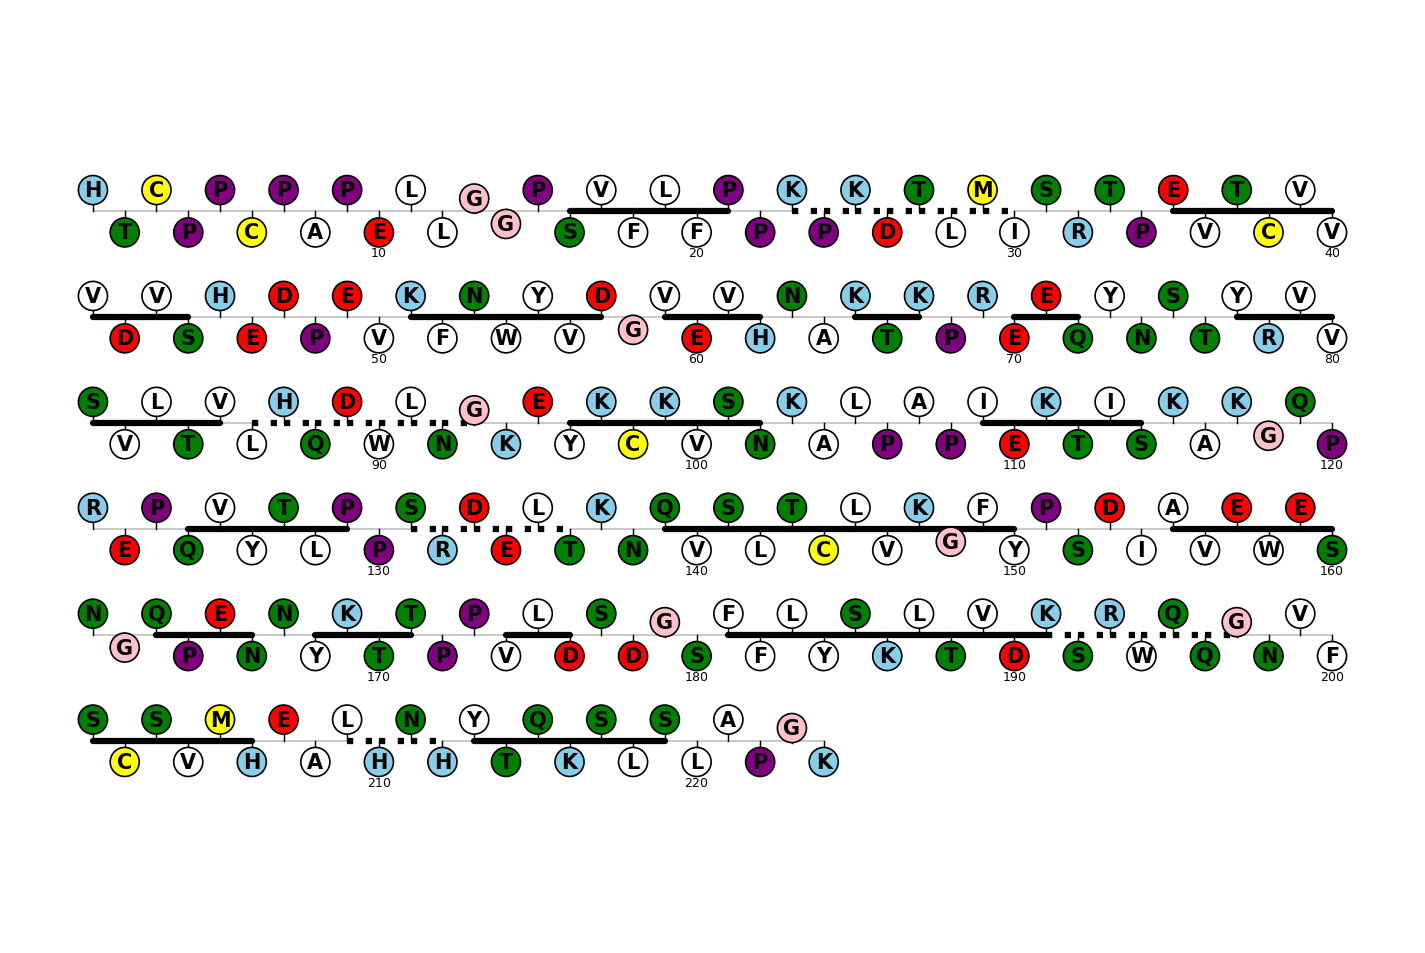

In [8]:
pdb_id = "4W4O"
chain_id = "A"
model = 1

arr, pdbx_file = load_structure_rcsb_safe(pdb_id, model=model)
res_ids, res_names = residue_table_full_chain(arr, chain_id, pdbx_file=pdbx_file)

print(f"Loaded structure {pdb_id} chain {chain_id} with {len(res_ids)} residues.")

sse = get_sse_biotite(arr, chain_id, pdbx_file=pdbx_file)

rail_xy, bead_xy, seg_tag = build_feature_map_layout(res_ids, res_names, sse)

scale = inflate_until_clean(rail_xy, bead_xy, res_ids, res_names, seg_tag,
                            label_period=10, label_mode="absolute")


rail2 = rail_xy * scale
bead2 = bead_xy * scale
# preview
fig, ax = plt.subplots(figsize=(12,8), dpi=150)
plot_for_overlap(ax, rail2, bead2, res_ids, res_names, seg_tag,
                 label_period=10, label_mode="absolute")
plt.show()


